In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pyhf
import pyhf.readxml
from ipywidgets import interact, fixed

# Binned HEP Statistical Analysis in Python

## HistFactory

HistFactory is a popular framework to analyze binned event data and commonly used in High Energy Physics. At its core it is a template for building a statistical model from individual binned distribution ('Histograms') and variations on them ('Systematics') that represent auxiliary measurements (for example an energy scale of the detector which affects the shape of a distribution)

## pyhf

`pyhf` is a work-in-progress standalone implementation of the HistFactory p.d.f. template and an implementation of the test statistics and asymptotic formulae described in the paper by Cowan, Cranmer, Gross, Vitells: *Asymptotic formulae for likelihood-based tests of new physics* [[arxiv:1007.1727](https://arxiv.org/abs/1007.1727)].

Models can be defined using JSON specification, but existing models based on the XML + ROOT file scheme are readable as well.

## The Demo

The input data for the statistical analysis was built generated using the containerized workflow engine [yadage](https://github.com/diana-hep/yadage) (see demo from KubeCon 2018 [[youtube](https://github.com/diana-hep/yadage)]). Similarly to Binder this utilizes modern container technology for reproducible science. Below you see the execution graph leading up to the model input data at the bottom.

/home/mcf/miniconda3/envs/pyhf/lib/python3.6/site-packages/ipykernel_launcher.py:3: ResourceWarning: unclosed file <_io.BufferedReader name='workflow.gif'>
  This is separate from the ipykernel package so we can avoid doing imports until



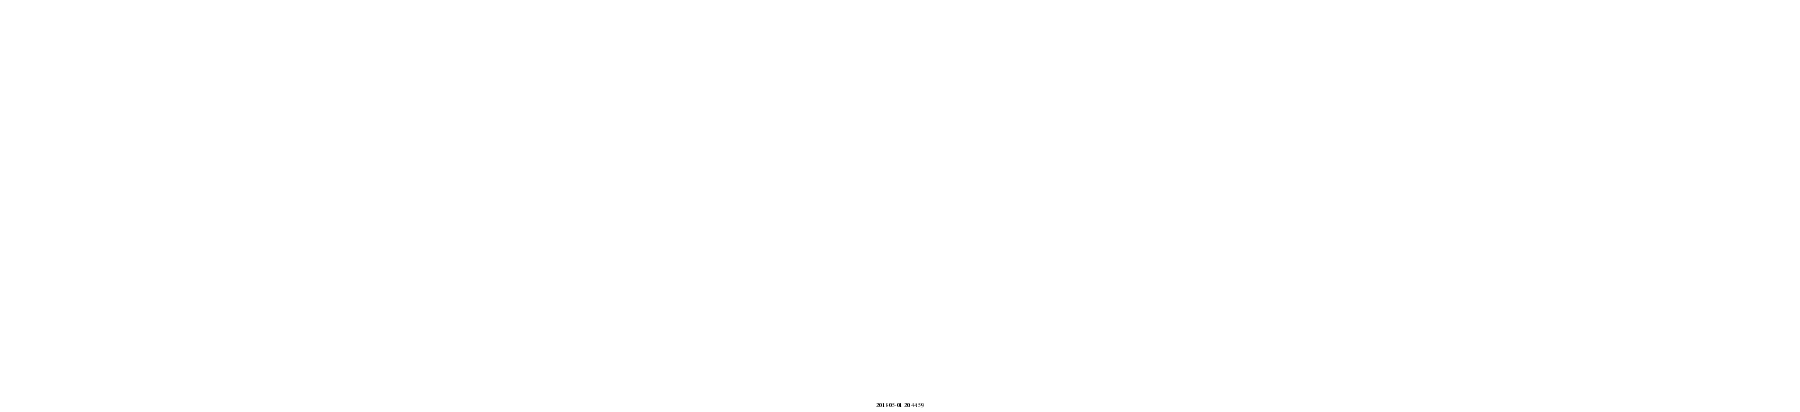

In [3]:
import base64
from IPython.core.display import display, HTML
anim = base64.b64encode(open('workflow.gif','rb').read()).decode('ascii')
HTML('<img src="data:image/gif;base64,{}">'.format(anim))

## Read in the Model from XML and ROOT

The ROOT files are read using scikit-hep's [uproot](https://github.com/scikit-hep/uproot) module.

In [4]:
parsed = pyhf.readxml.parse('meas.xml',os.getcwd())
obs_data = parsed['data']['channel1'] 

From the parsed data, we construct a probability density function (p.d.f). As the model includes systematics a number of implied "auxiliary measurements" must be added to the observed data distribution.

In [5]:
pdf = pyhf.Model({'channels': parsed['channels'], 'parameters': parsed['toplvl']['measurements'][0]['config']['parameters']}, poiname = 'SigXsecOverSM')
data = obs_data + pdf.config.auxdata

The p.d.f is build from one data-drived "qcd" (or multijet) estimate and two Monte Carlo-based background samples and is parametrized by five parameters: One parameter of interest `SigXsecOverSM` and four *nuisance parameters* that affect the shape of the two Monte Carlo background estimates (both weight-only and shape systematics)

In [6]:
par_name_dict = {k: v['slice'].start for k,v in pdf.config.par_map.items()}
print('Samples:\n {}'.format(pdf.config.samples))
print('Parameters:\n {}'.format(par_name_dict))

Samples:
 ['qcd', 'signal', 'mc2', 'mc1']
Parameters:
 {'SigXsecOverSM': 0, 'mc1_weight_var1': 1, 'mc1_shape_conv': 2, 'mc2_weight_var1': 3, 'mc2_shape_conv': 4}


In [7]:
all_par_settings = {n[0]: tuple(m) for n,m in zip(sorted(reversed(list(par_name_dict.items())), key=lambda x:x[1]), pdf.config.suggested_bounds())}
default_par_settings = {n[0]: sum(tuple(m))/2.0 for n,m in all_par_settings.items()}

def get_mc_counts(pars):
    deltas, factors = pdf._modifications(pars)
    allsum = pyhf.tensorlib.concatenate(deltas + [pyhf.tensorlib.astensor(pdf.thenom)])
    nom_plus_delta = pyhf.tensorlib.sum(allsum,axis=0)
    nom_plus_delta = pyhf.tensorlib.reshape(nom_plus_delta,(1,)+pyhf.tensorlib.shape(nom_plus_delta))
    allfac = pyhf.tensorlib.concatenate(factors + [nom_plus_delta])
    return pyhf.tensorlib.product(allfac,axis=0)

animate_plot_pieces = None
def init_plot(fig, ax, par_settings):
    global animate_plot_pieces
    
    nbins = sum(list(pdf.config.channel_nbins.values()))
    x = np.arange(nbins)
    data = np.zeros(nbins)
    items = []
    for i in [3, 2, 1, 0]:
        items.append(ax.bar(x, data, 1, alpha=1.0))
    animate_plot_pieces = (items, ax.scatter(x, obs_data, c='k', alpha=1., zorder=99))

def animate(ax=None, fig=None, **par_settings):
    global animate_plot_pieces
    items, obs = animate_plot_pieces
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k,v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    rectangle_collection = zip(*map(lambda x: x.patches, items))
    
    for rectangles,binvalues in zip(rectangle_collection, mc_counts[:,0].T):
        offset = 0
        for sample_index in [3, 2, 1, 0]:
            rect = rectangles[sample_index]
            binvalue = binvalues[sample_index]
            rect.set_y(offset)
            rect.set_height(binvalue)
            offset += rect.get_height()

    fig.canvas.draw()

def plot(ax=None, order=[3, 2, 1, 0], **par_settings):
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k,v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    bottom = None
    # nb: bar_data[0] because evaluating only one parset
    for i,sample_index in enumerate(order):
        data = mc_counts[sample_index][0]
        x = np.arange(len(data))
        ax.bar(x, data, 1, bottom = bottom, alpha = 1.0)
        bottom = data if i==0 else bottom + data
    ax.scatter(x, obs_data, c = 'k', alpha = 1., zorder=99)

## Interactive Exploration of a HistFactory Model

One advantage of a pure-python implementation of Histfactory is the ability to explore the pdf interactively within the setting of a notebook. Try moving the sliders and oberserve the effect on the samples. For example changing the parameter of interest `SigXsecOverSM` (or µ) controls the overall normalization of the (BSM) signal sample (µ=0 for background-only and µ=1 for the nominal signal-plus-background hypothesis)

<IPython.core.display.Javascript object>


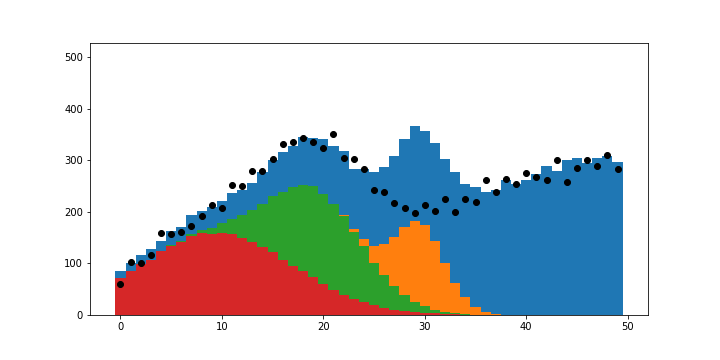

interactive(children=(IntSlider(value=5, description='SigXsecOverSM', max=10), FloatSlider(value=0.0, descript…

In [8]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax.set_ylim(0, 1.5 * np.max(obs_data))

init_plot(fig, ax, default_par_settings)
interact(animate, fig=fixed(fig), ax=fixed(ax), **all_par_settings);

In [9]:
nominal = pdf.config.suggested_init()
background_only = pdf.config.suggested_init()
background_only[pdf.config.poi_index] = 0.0
best_fit = pyhf.optimizer.unconstrained_bestfit(
    pyhf.utils.loglambdav, data, pdf, pdf.config.suggested_init(), pdf.config.suggested_bounds())

/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


## Fitting

We can now fit the statistical model to the observed data. The best fit of the signal strength is close to the background-only hypothesis.

<IPython.core.display.Javascript object>


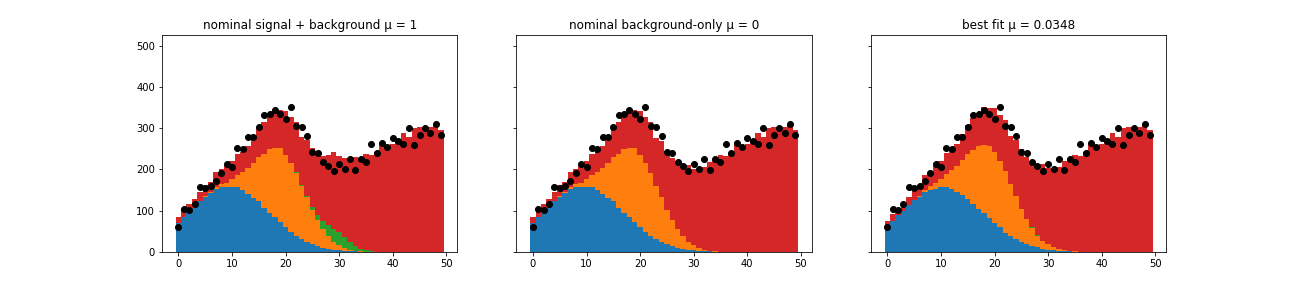

In [10]:
f,(ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, sharex=True)
f.set_size_inches(18,4)
ax1.set_ylim(0,1.5*np.max(obs_data))
ax1.set_title(u'nominal signal + background µ = 1')
plot(ax = ax1, **{k: nominal[v] for k,v in par_name_dict.items()})

ax2.set_title(u'nominal background-only µ = 0')
plot(ax = ax2, **{k: background_only[v] for k,v in par_name_dict.items()})

ax3.set_title(u'best fit µ = {:.3g}'.format(best_fit[pdf.config.poi_index]))
plot(ax = ax3, **{k: best_fit[v] for k,v in par_name_dict.items()})

## Interval Estimation (Computing Upper Limits on µ)

A common task in the statistical evaluation of High Energy Physics data analyses is the estimation of confidence intervals of parameters of interest. The general strategy is to perform a series of hypothesis tests and then *invert* the tests in order to obtain an interval with the correct coverage properties.

A common figure of merit is a modified p-value, CLs. Here we compute an upper limit based on a series of CLs tests.

In [11]:
def plot_results(ax, test_mus, cls_obs, cls_exp, test_size=0.05):
    ax.plot(mu_tests, cls_obs, c = 'k')
    for i,c in zip(range(5),['k','k','k','k','k']):
        ax.plot(mu_tests, cls_exp[i], c = c, linestyle = 'dotted' if i!=2 else 'dashed')
    ax.fill_between(test_mus,cls_exp[0],cls_exp[-1], facecolor = 'y')
    ax.fill_between(test_mus,cls_exp[1],cls_exp[-2], facecolor = 'g')
    ax.plot(test_mus,[test_size]*len(test_mus), c = 'r')
    ax.set_ylim(0,1)

def invert_interval(test_mus, cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        y_vals = cls_exp_sigma
        point05cross['exp'].append(np.interp(test_size, list(reversed(y_vals)), list(reversed(test_mus))))
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size, list(reversed(y_vals)), list(reversed(test_mus)))
    return point05cross

/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered 

/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered 

/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/jovyan/pyhf/pyhf/tensor/numpy_backend.py:173: RuntimeWarning: invalid value encountered 

<IPython.core.display.Javascript object>


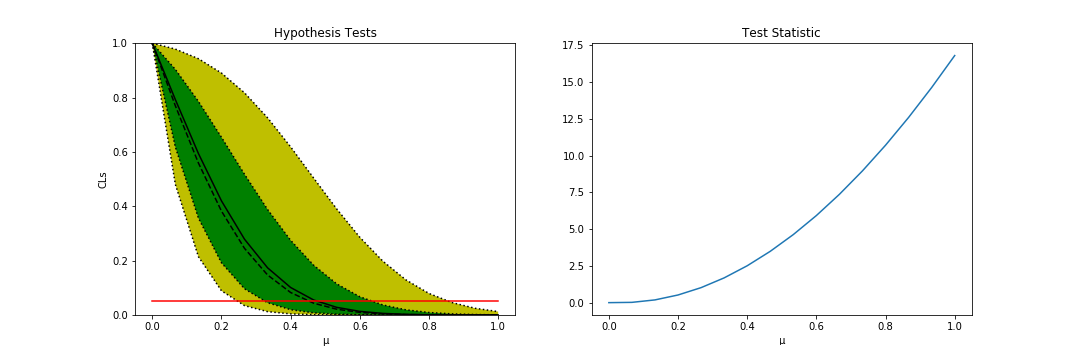

In [12]:
mu_tests = np.linspace(0, 1, 16)
hypo_tests = [pyhf.utils.hypotest(mu, data, pdf, pdf.config.suggested_init(), pdf.config.suggested_bounds(),
                                 return_expected_set=True, return_test_statistics=True)
              for mu in mu_tests]

test_stats = np.array([test[-1][0] for test in hypo_tests]).flatten()
cls_obs = np.array([test[0] for test in hypo_tests]).flatten()
cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax1.set_title(u'Hypothesis Tests')
ax1.set_ylabel(u'CLs')
ax1.set_xlabel(u'µ')
plot_results(ax1, mu_tests, cls_obs, cls_exp)


ax2.set_title(u'Test Statistic')
ax2.set_xlabel(u'µ')
ax2.plot(mu_tests,test_stats);

In [13]:
results = invert_interval(mu_tests, cls_obs, cls_exp)

print('Observed Limit: {:.2f}'.format(results['obs']))
print('-----')
for i, n_sigma in enumerate(np.arange(-2,3)):
    print('Expected Limit{}: {:.3f}'.format('' if n_sigma==0 else '({} σ)'.format(n_sigma),results['exp'][i]))

Observed Limit: 0.86
-----
Expected Limit(-2 σ): 0.248
Expected Limit(-1 σ): 0.327
Expected Limit: 0.455
Expected Limit(1 σ): 0.638
Expected Limit(2 σ): 0.858
